# Advanced Lane Finding #

In [1]:
#Basic Imports
import numpy as np
import glob
import cv2
#import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#from mpl_toolkits.axes_grid1 import ImageGrid

import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
FIGSIZE = (16, 8)

In [2]:
#Initializing some required variables
#lists to store the processed images which then I ultimately used to prepare combined grid of images

imgpoints = [] # 2D points in image plane
objpoints = [] # 3D points in real world space

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x, y coordinate

corner_images = []

undistorted_images = []

## Advanced Lane Finding Steps ##

* Camera Callibration
* Distortion Correction
* Color & Gradient threshhold
* Perspective transform
* Locate the Lane Lines and Fit a Polynomial
* Sliding window search
* Measuring Curvature


### Camera Callibration

In [3]:
# helper function to display images inline in a grid
def display(images, cols=None, maxcols=10, width=FIGSIZE[0], titles=None, callback=None):
    if cols is None:
        cols = len(images)
    n_cols = cols if cols < maxcols else maxcols
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(fig1, 111,
                     nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                     axes_pad=(0.1, 0.4),
                    )

    for index, img in enumerate(images):
        if titles is not None:
            grid1[index].set_title(titles[index])
        if len(img.shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(img)
        if callback is not None:
            callback(grid1[index], index)

#Used to draw Chessboard Corners on the chess board images. Also, imgpoints and objpoints are added to list.
def find_corners(img, nx=9, ny=6):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        corner_images.append(img)
        
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure(figsize=(14,10))
        plt.imshow(img)
        plt.show()
        #display(img,cols=5,titles=['Original {}'.format(i) for i in range(len(img))])
    else:
        corner_images.append(img)
        


### Distortion Correction

In [4]:
#Based on the imgpoints and objpoints found in previous function draw_corners, the Camera Matrix, distortion 
#coefficients, Radial distortion vector and tangential distortion vector are calculated. And then using this 
#camera matrix and distortion coefficient, the input image is undistorted
def undistort_img(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)

    return undist

### Color & Gradient threshhold

In [5]:
def thresh(img, thresh=(0,255)):
    # 1) Create a mask of 1's where image is > thresh_min and < thresh_max
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    # 2) Return this mask as your binary_output image
    return binary

#Applies color threshold to R channel and S channel images and then combines the pixels of this images.
def colorthresh(img):
    r_channel = img[:,:,2]
    r_thresh = thresh(r_channel, thresh=(200,255))
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh = thresh(s_channel, thresh=(90,255))
    color_combined = np.zeros_like(s_thresh)
    color_combined[((r_thresh==1)|(s_thresh==1))] = 1
    return color_combined



def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # 5) Return this mask as your binary_output image
    return sbinary

#Applies the Gradient magnitude threshold with kernal size of 9 and threshold values of 30 and 100
def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100)):
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # 4) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


#Applies the Gradient Direction threshold with kernal size of 15 and threshold values of 0.7 and 1.3 as given in the sample code
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2) Take the absolute value of the x and y gradients
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # 4) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image  
    return binary_output

# Apply each of the thresholding functions
def applythresholds(img):
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img)
    dir_binary = dir_threshold(img)

    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx==1)|(mag_binary == 1)) & ((grady == 1)|(mag_binary == 1))] = 1
    
    return grad_combined

def combinethresh(grad_thresh, color_thresh):
    combined_color_grad = np.zeros_like(grad_thresh)
    combined_color_grad[(grad_thresh==1) & (color_thresh==1)] = 1
    return combined_color_grad

### Perspective transform

In [6]:
#image warping step
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])

    #top right, bottom right, bottom left, top left
    src = np.float32([[490, 482],[810, 482], [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img, M, Minv

### Testing Camera Caliberation ###

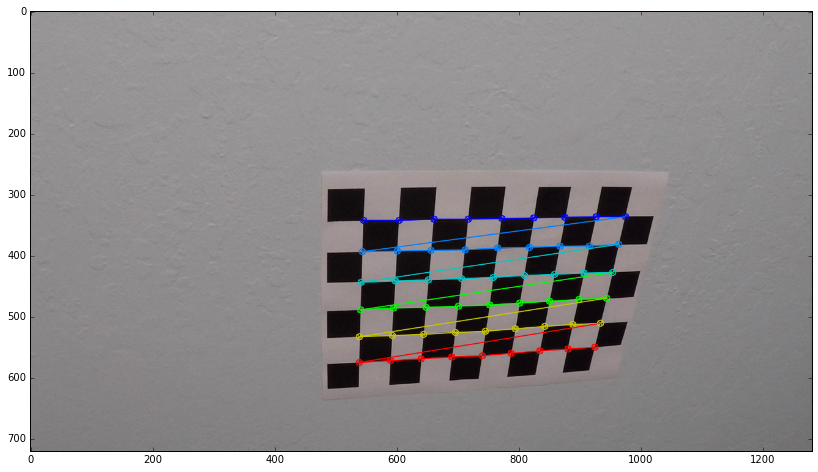

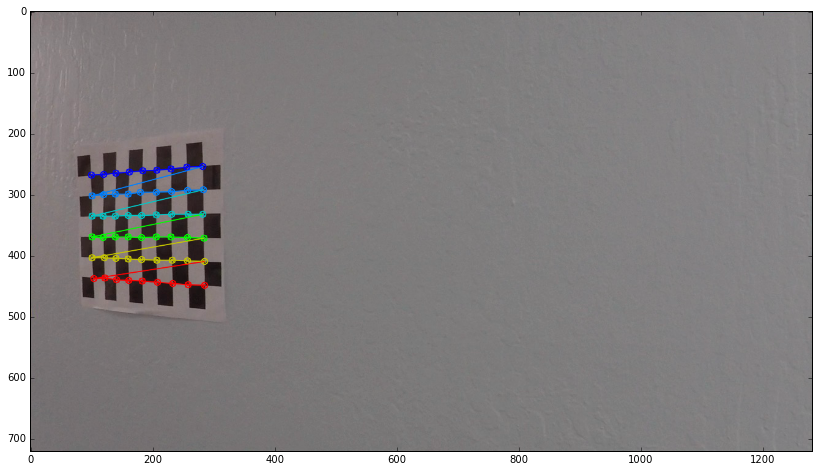

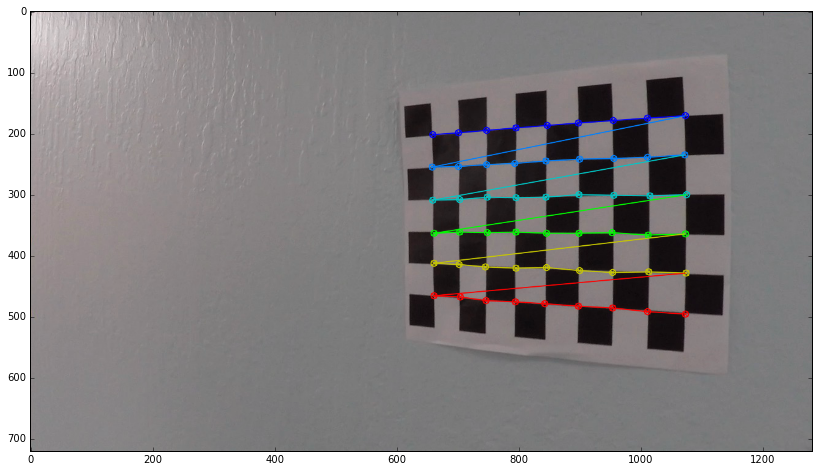

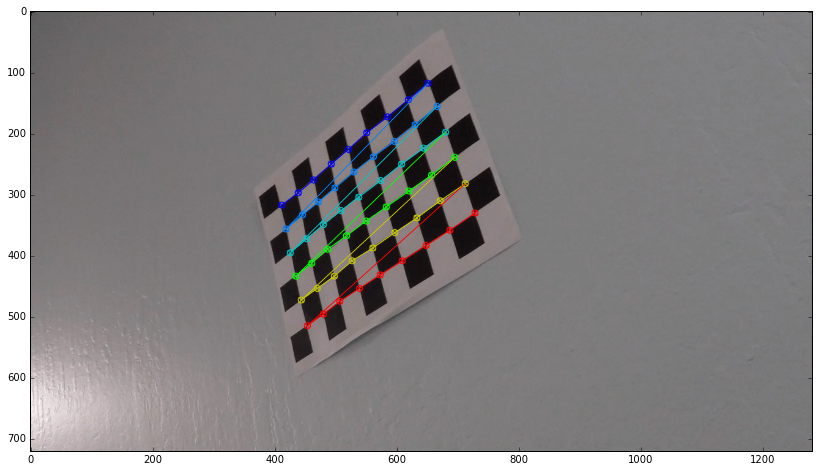

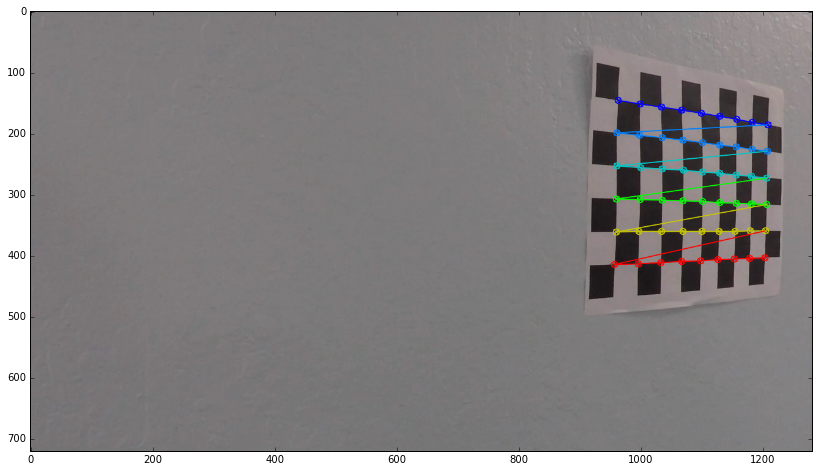

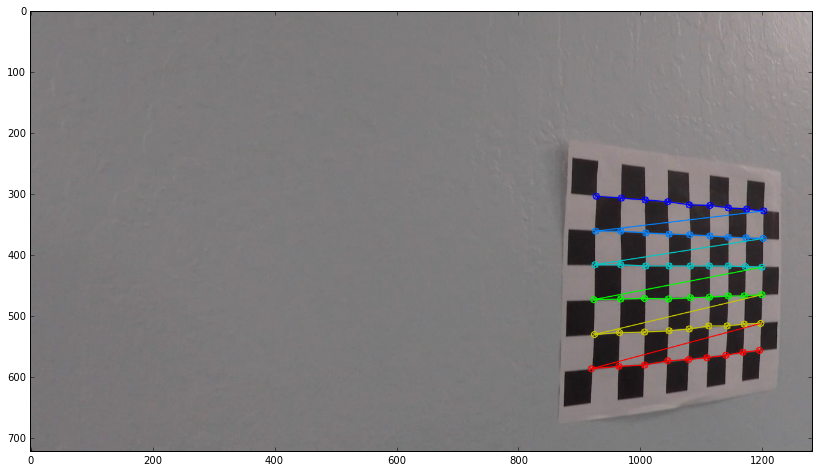

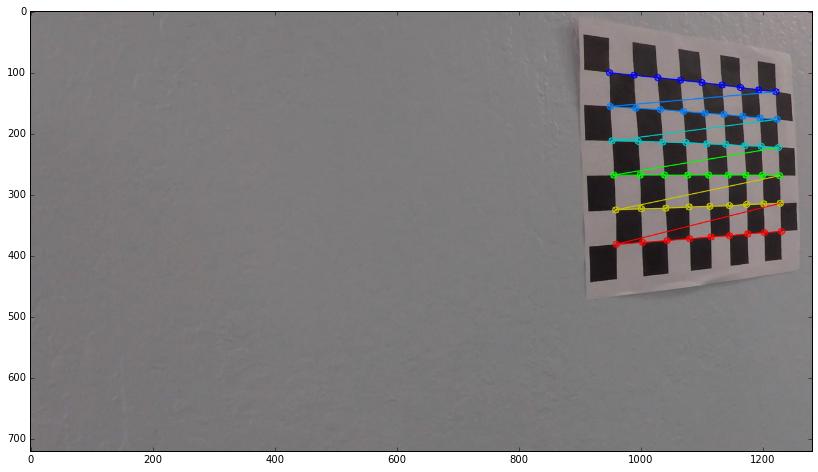

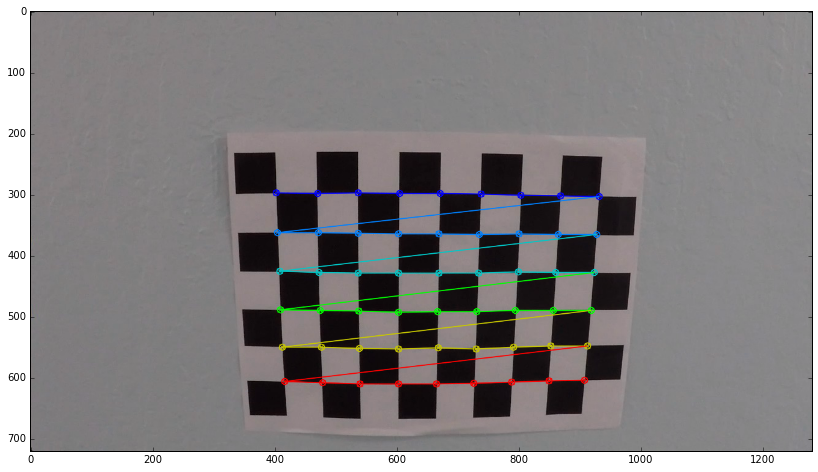

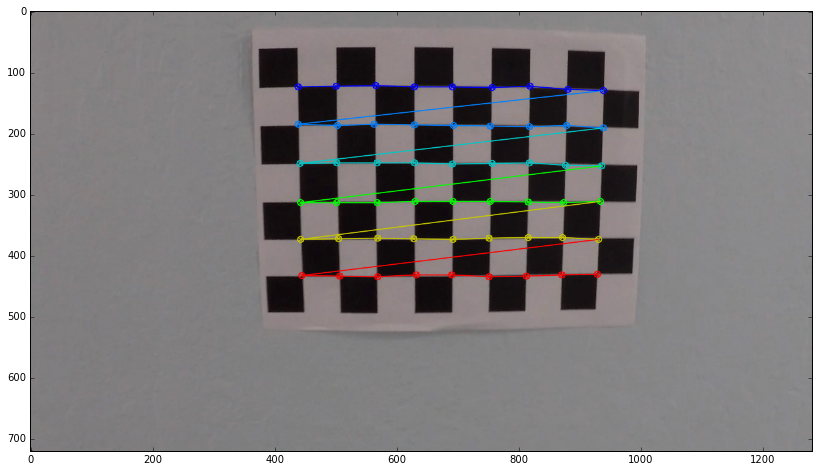

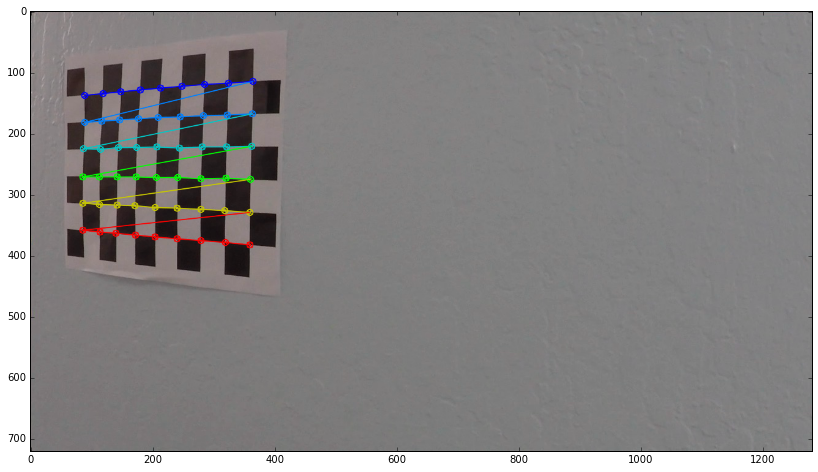

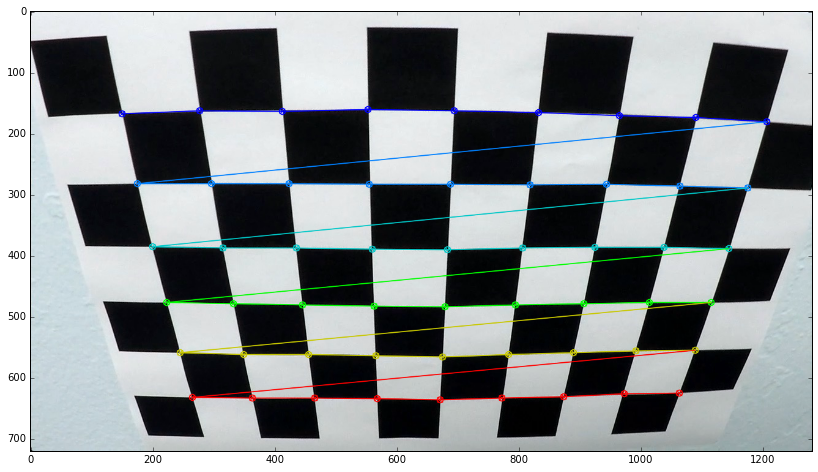

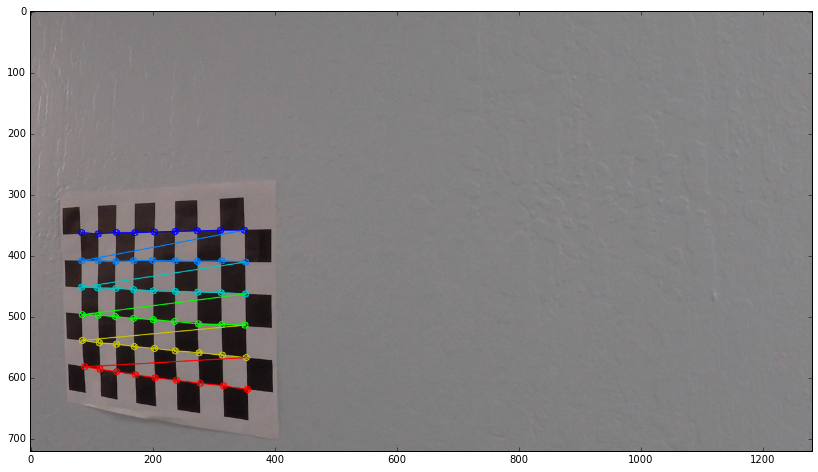

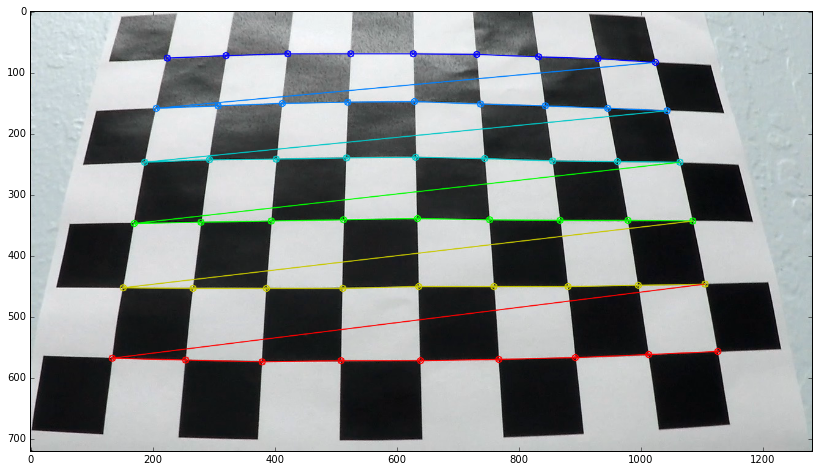

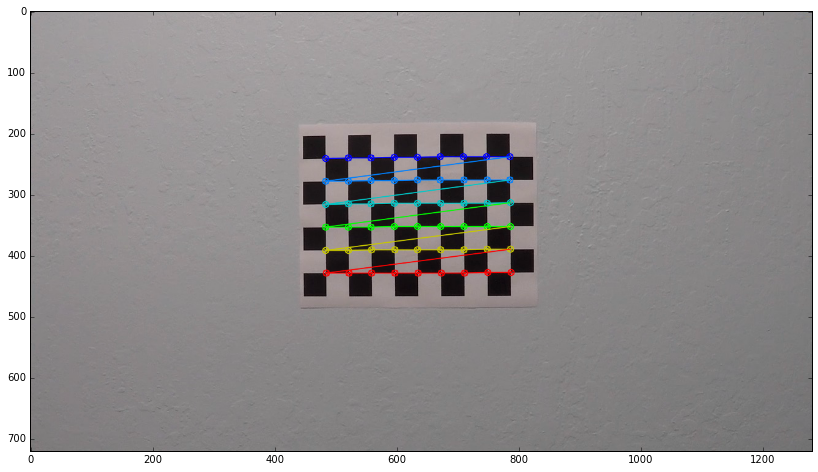

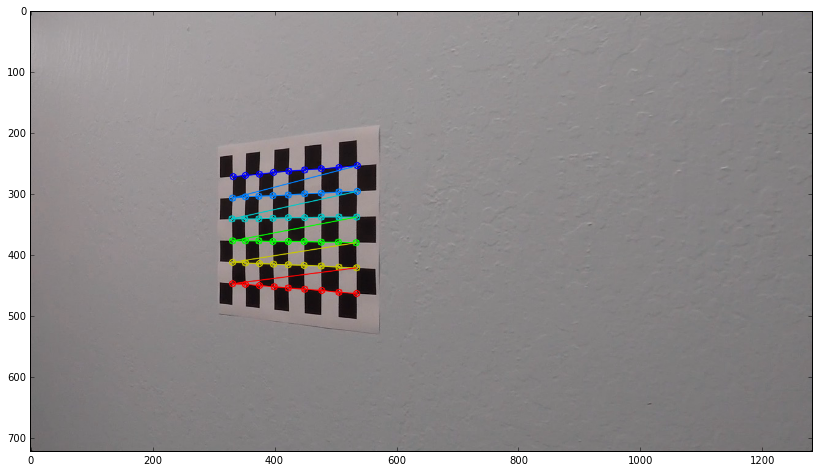

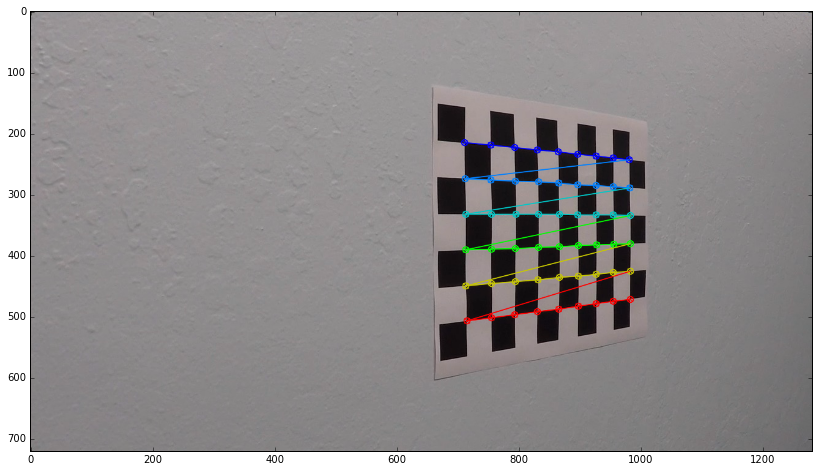

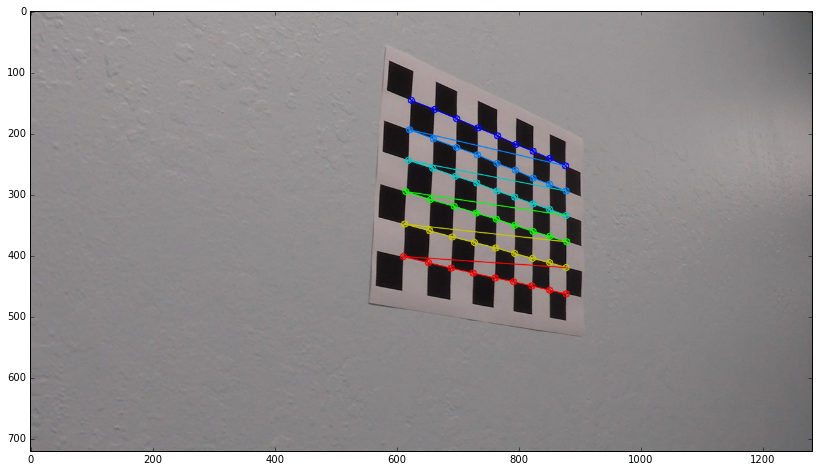

In [7]:
#To Calibrate Camera
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    find_corners(img)

## Locate the Lane Lines and Fit a Polynomial ##


In [8]:

def find_lane(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx
    
def calculate_curvature_offset(ploty, lefty, righty, leftx, rightx, w, h):
    y_eval = np.max(ploty)
    lane_width_pix = w * 0.57
    ym_per_pix = 23/h # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_width_pix # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvrad = np.mean([left_curverad, right_curverad])
    
    image_centre = lane_width_pix * xm_per_pix / 2
    
    vehicle_centre = np.mean([left_fit_cr, right_fit_cr])
    
    vehicle_offset = abs(image_centre - vehicle_centre)
    
    return curvrad, vehicle_offset
    
def render_lane(binary_warped, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset):
    # step 1: Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    img_size = (color_warp.shape[1], color_warp.shape[0])
    
    # step 2: Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # step 3: Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # step 4: Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size)

    # step 5: Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    # step 6: print road position
    cv2.putText(result, 'Distance from centre (offset): {:.2f} m'.format(vehicle_offset), (100,80), fontFace = 16,\
                    fontScale = 1, color=(255,255,255), thickness = 2)
       
    # step 7: print curvature
    cv2.putText(result, 'Radius of Curvature {} m'.format(int(curverad)), (120,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result

## Applying thresholds on a test image ##

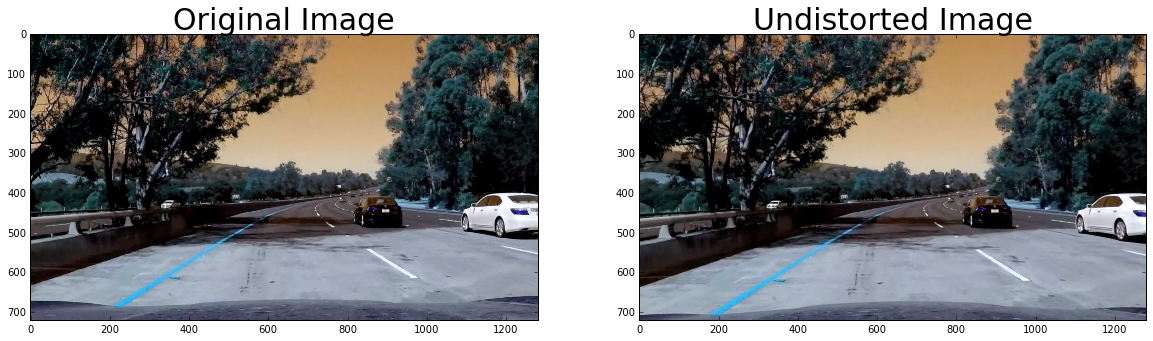

In [9]:
path = "test_images/"
file = "test5.jpg"
img = cv2.imread(path+file)
undist = undistort_img(img)
color_thresholded = colorthresh(undist)
grad_thresholded = applythresholds(color_thresholded)
combined_thresholded = combinethresh(grad_thresholded, color_thresholded)
warped_img, M, Minv = perspective_transform(combined_thresholded)


# image processing
processed_images = plt.figure(figsize=(14,10))

axis = processed_images.add_subplot(3,2,1)
axis.set_xlabel("Source", fontsize=16)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

axis = processed_images.add_subplot(3,2,2)
axis.set_xlabel("Undistorted",fontsize=16)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))

axis = processed_images.add_subplot(3,2,3)
axis.set_xlabel("Color Thresholded",fontsize=16)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(color_thresholded, cmap="gray")

axis = processed_images.add_subplot(3,2,4)
axis.set_xlabel("Gradient Thresholded",fontsize=16)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(grad_thresholded, cmap="gray")

axis = processed_images.add_subplot(3,2,5)
axis.set_xlabel("Combined Thresholded",fontsize=16)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(combined_thresholded, cmap="gray")

axis = processed_images.add_subplot(3,2,6)
axis.set_xlabel("Warped",fontsize=16)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(warped_img, cmap="gray")

processed_images.tight_layout(h_pad=0, w_pad=0)
processed_images.savefig('output_images/processed_images.png')

## Locate Lane on a single image ##

Radius of Curvature:  341127.777798 m
 Distance from the centre:  0.756398218829 m


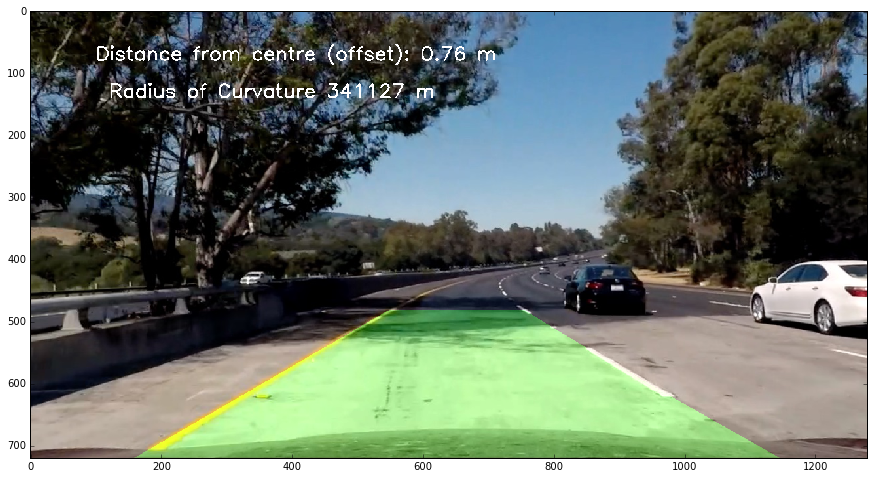

In [11]:
ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx = find_lane(warped_img)

#step1: Measurement of road curvature and offset
curverad, vehicle_offset = calculate_curvature_offset(ploty, lefty, righty, leftx, rightx, undist.shape[1], undist.shape[0])
print ("Radius of Curvature: ", curverad,"m\n", "Distance from the centre: ", vehicle_offset,"m")

#step2: render the lane on top of the original image
result = render_lane(warped_img, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset)

plt.subplots(figsize=(15, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB),interpolation='nearest', aspect='auto')

## Advanced Lane detection Pipeline ##


In [ ]:
def advanced_lane_detection_pipeline(img):
    undist = undistort_img(img)
    color_thresholded = colorthresh(undist)
    grad_thresholded = applythresholds(color_thresholded)
    combined_thresholded = combinethresh(grad_thresholded, color_thresholded)
    warped_img, M, Minv = perspective_transform(combined_thresholded)
    ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx = find_lane(warped_img)
    curverad, vehicle_offset = calculate_curvature_offset(ploty, lefty, righty, leftx, rightx, undist.shape[1], undist.shape[0])
    result = render_lane(warped_img, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset)
    return result
    

## Video Processing ##
In the following section, the video was provided to the processing pipeline and the Lane Line Detection was carried out in the output video.

In [ ]:
project_video_processed = 'project_video_processed.mp4'
video = VideoFileClip("project_video.mp4")
processed_clip = video.fl_image(advanced_lane_detection_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(project_video_processed, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


 13%|█▎        | 162/1261 [04:59<33:13,  1.81s/it]

In [ ]:
project_video_processed = 'project_video_processed.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_processed))